# Data Quality Assessment

In [1]:
import warnings
warnings.filterwarnings('ignore')

%config IPCompleter.greedy=True

In [2]:
import pandas as pd

extract = '../01_data/extract_final.csv'
names=['ticket', 'type', 'client', 'issuer', 'inquiry', 'state', 'meta']

corpus = pd.read_csv(extract, sep=',', encoding='ansi', names=names, skiprows=[0])
corpus['ticket'] = corpus['ticket'].astype(str)

corpus.head()

,ticket,type,client,issuer,inquiry,state,meta
0,2019030563000120,Fehler in der App,SVBA,3,Ich kann die Bilder in übungen nicht Bearbeite...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
1,2019030563000120,Fehler in der App,SVBA,1,Wir haben Ihre Support-Anfrage erhalten besten...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
2,2019030563000020,Fehler in der App,SVBA,3,Bei mir erscheinen eingefügte Bilder im Fachre...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
3,2019030563000020,Fehler in der App,SVBA,1,Damit wir das Problem besser eingrenzen können...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...
4,2019030463000110,Fehler in der App,FOMA,1,Besten Dank für Ihre Support-Anfrage. Wir verm...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...


### Umfang der Daten
* 5170 Zeilen
* 1274 Nullwerte
* 115 Duplikate

Am Schluss bleiben: 3781 Zeilen

In [3]:
len(corpus)

5170

#### Nullwerte

In [4]:
len(corpus[corpus['inquiry'].isnull()])

1274

In [5]:
# corpus.dropna(axis=0, how='any', inplace=True)
corpus = corpus[~corpus['inquiry'].isnull()]
corpus['inquiry'].count()

3896

#### Duplikate und Nullwerte entfernen

In [6]:
corpus['inquiry'] = corpus['inquiry'].str.lower()
corpus.duplicated(subset='inquiry').sum()

115

In [7]:
corpus.drop_duplicates(subset='inquiry', keep='last', inplace=True)
len(corpus)

3781

### Matchen Frage (3) zu Antwort (1) via Ticketnummer
Damit dies funktioniert reduzieren wir den Datensatz weiter. Alle Zeilen bei denen die Ticket Nummer nur einmal vorkommt werden gelöscht.

In [8]:
corpus = corpus[corpus.duplicated(subset='ticket', keep=False)]
len(corpus)

3123

3123 ist eine ungerade Zahl. Heisst *n* Tickets kommen mehr als doppelt vor. Gehen wir das auf den Grund.

In [9]:
corpus['ticket'].describe()

count                 3123
unique                1561
top       2018082963000410
freq                     3
Name: ticket, dtype: object

In [10]:
corpus.loc[corpus['ticket'] == '2018082963000410']

,ticket,type,client,issuer,inquiry,state,meta
1431,2018082963000410,Fehler in der App,VEL,3,"im fachbuch \""fk\"" gehe die seitenlink im sac...",closed successful,App: beook 5.4.3 | Model: 12 cores | Platform:...
1432,2018082963000410,Fehler in der App,VEL,3,wie schon gemeldet habe ich das gleiche proble...,closed successful,App: beook 5.4.3 | Model: 12 cores | Platform:...
1433,2018082963000410,Fehler in der App,VEL,1,guten tag thomas gabathuler besten dank für d...,closed successful,App: beook 5.4.3 | Model: 12 cores | Platform:...


Nun entfernen wir die Zeile mit Index *1432*

In [11]:
corpus.drop([1432], inplace=True)
len(corpus)

3122

In [12]:
corpus['ticket'].describe()

count                 3122
unique                1561
top       2018090563000090
freq                     2
Name: ticket, dtype: object

#### Wieviele davon sind Fragen?

In [13]:
question = 3
answer = 1

corpus.loc[corpus['issuer'] == answer]['issuer'].sum()

1559

In [14]:
corpus.loc[corpus['issuer'] == question]['issuer'].sum() // 3

1563

Sieht so aus als wären 2 Tickets die 2x aus Fragen bestehen. Finden wir sie.

In [15]:
import numpy as np

group_by_ticket = corpus.groupby(['ticket']).apply(lambda t: 'fraud' if t['issuer'].mean() != 2.0 else np.nan)
group_by_ticket.dropna()

ticket
2016120263000050    fraud
2016121263000010    fraud
dtype: object

Üperprüfen wir ob diese zwei Tatsächlich 2x aus Fragen bestehen.

In [16]:
corpus.loc[corpus['ticket'] == '2016120263000050']

,ticket,type,client,issuer,inquiry,state,meta
4334,2016120263000050,Fehler in der App,SVBA,3,freundliche grüsse felix buchenberger berufsfa...,closed successful,App: beook 4.2.0 | Model: 8 cores | Platform: ...
4335,2016120263000050,Fehler in der App,SVBA,3,wollte gerade eben ein hypercam filmli machen ...,closed successful,App: beook 4.2.0 | Model: 8 cores | Platform: ...


In [17]:
corpus.loc[corpus['ticket'] == '2016121263000010']

,ticket,type,client,issuer,inquiry,state,meta
4308,2016121263000010,Fehler in der App,WINGS,3,ich habe gesehen dass ich mitglied dieser grup...,closed successful,App: beook 4.2.3 | Model: 4 cores | Platform: ...
4309,2016121263000010,Fehler in der App,WINGS,3,ich habe gestern auf meinem windows pc zu haus...,closed successful,App: beook 4.2.3 | Model: 4 cores | Platform: ...


In [18]:
corpus.drop([4308, 4309], inplace=True)
corpus.drop([4334, 4335], inplace=True)
len(corpus)

3118

#### Fragen und Antworten zusammenfügen

In [19]:
q_and_a_corpus = corpus.loc[corpus['issuer'] == question]
len(q_and_a_corpus)

1559

In [20]:
q_and_a_corpus['answer'] = corpus.loc[corpus['issuer'] == answer]['inquiry'].values
q_and_a_corpus.head()

,ticket,type,client,issuer,inquiry,state,meta,answer
0,2019030563000120,Fehler in der App,SVBA,3,ich kann die bilder in übungen nicht bearbeite...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...,wir haben ihre support-anfrage erhalten besten...
2,2019030563000020,Fehler in der App,SVBA,3,bei mir erscheinen eingefügte bilder im fachre...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...,damit wir das problem besser eingrenzen können...
5,2019030463000110,Fehler in der App,FOMA,3,lückentexte weg daten verloren gegangen von pp...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...,besten dank für ihre support-anfrage. wir verm...
10,2019022863000110,Anmeldung / Aktivierung,AGVS,3,bitte deaktivieren sie dieses gerät. vielen dank.,closed successful,User account exists: Yes | | App: beook v5.5.1...,wir haben alle ihre geräte auf dem lizenzser...
11,2019022863000100,Anmeldung / Aktivierung,BEOOK,3,diese sind meine aktivierungscodes: gesellscha...,closed successful,User account exists: Yes | | App: beook v5.5.1...,guten tag corina gisler besten dank für ihre a...


Überprüfen wir das kurz

In [21]:
tickets = ['2015081263000080', '2015081763000050', '2015081763000060', '2015081763000110', '2015082463000180']
for t in tickets:
    print(corpus.loc[corpus['ticket'] == t].inquiry, '\n')

5167     danke habe es korrigiert. war ein seltener fa...
5168    habe soeben gesb ah gelöscht und danach die ap...
Name: inquiry, dtype: object 

5165    guten tag herr hirsiger können sie uns bitte m...
5166    das elehrmittel funktioniert auf meinem gerät ...
Name: inquiry, dtype: object 

5163    guten tag herr rados haben sie probleme mit un...
5164    falls sie ein problem mit der anmeldung oder d...
Name: inquiry, dtype: object 

5161    guten tag schlatter yassin bitte beschreiben s...
5162    als ich die software gestartet habe funktionie...
Name: inquiry, dtype: object 

5159    hallo marcel besten dank für deinen bericht. d...
5160    falls sie ein problem mit der anmeldung oder d...
Name: inquiry, dtype: object 



sehr gut das matching hat funktioniert.

#### export to csv

In [22]:
q_and_a_corpus.to_csv(r'../01_data/ionesoft_extract_final_clean.csv', index=None, header=True)

### Antwort zu Kategorie
Nun müssen die Antworten einer Kategorie zugeorndet werden.

In [23]:
template = '../01_data/standard_template.csv'
names=['name', 'text']

template_corpus = pd.read_csv(template, sep=';', encoding='ansi', names=names, skiprows=[0])

template_corpus.head()

,name,text
0,"Abmelden, neu anmelden",Sie sind aktuell nicht mehr korrekt in der App...
1,"Abmelden, neu anmelden (FR)",Vous n'êtes actuellement plus correctement con...
2,Aktivierungscode falsch,Wir können leider keinen Aktivierungscode im S...
3,"Altes Ticket, Problem gelöst?","Wir haben festgestellt, dass Sie noch ein offe..."
4,"Anderer Anbieter, falsches Login",Sie sind beim falschen Anbieter angemeldet!<br...


#### FR, IT entfernen

In [24]:
template_corpus = template_corpus.loc[template_corpus['name'].str.contains('\(FR\)', case=False, regex=True) == False]
template_corpus = template_corpus.loc[template_corpus['name'].str.contains('FR', case=False, regex=True) == False]
template_corpus = template_corpus.loc[template_corpus['name'].str.contains('\(IT\)', case=False, regex=True) == False]

template_corpus.head()

,name,text
0,"Abmelden, neu anmelden",Sie sind aktuell nicht mehr korrekt in der App...
2,Aktivierungscode falsch,Wir können leider keinen Aktivierungscode im S...
3,"Altes Ticket, Problem gelöst?","Wir haben festgestellt, dass Sie noch ein offe..."
4,"Anderer Anbieter, falsches Login",Sie sind beim falschen Anbieter angemeldet!<br...
5,Android: alte beook version -> updaten!,Vielen Dank für ihre Support-Anfrage.<br />Ihr...


Annahme enthält die Antwort _abmelden_ oder _anmelden_ handelt es sich um ein _Abmelden, neu anmelden_ Problem

In [25]:
import re

def get_words_between(text, s, e):
    word_list = [w for w in text.split(' ')]
    
    return str.join(' ', word_list[s:e]).lower()


template_corpus['expr'] = template_corpus['text'].apply(lambda x: get_words_between(x, 0, 5))
template_corpus.head()

,name,text,expr
0,"Abmelden, neu anmelden",Sie sind aktuell nicht mehr korrekt in der App...,sie sind aktuell nicht mehr
2,Aktivierungscode falsch,Wir können leider keinen Aktivierungscode im S...,wir können leider keinen aktivierungscode
3,"Altes Ticket, Problem gelöst?","Wir haben festgestellt, dass Sie noch ein offe...","wir haben festgestellt, dass sie"
4,"Anderer Anbieter, falsches Login",Sie sind beim falschen Anbieter angemeldet!<br...,sie sind beim falschen anbieter
5,Android: alte beook version -> updaten!,Vielen Dank für ihre Support-Anfrage.<br />Ihr...,vielen dank für ihre support-anfrage.<br


#### Kategorisieren

In [26]:
def search_and_replace(expr, category):
    q_and_a_corpus.loc[
        q_and_a_corpus['answer'].str.contains(expr),
        'answer'
    ] = category


for row in template_corpus.itertuples(index=True, name='Pandas'):
    search_and_replace(getattr(row, 'expr'), getattr(row, 'name'))

In [27]:
q_and_a_corpus.head()

,ticket,type,client,issuer,inquiry,state,meta,answer
0,2019030563000120,Fehler in der App,SVBA,3,ich kann die bilder in übungen nicht bearbeite...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...,Fehlerbericht senden
2,2019030563000020,Fehler in der App,SVBA,3,bei mir erscheinen eingefügte bilder im fachre...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...,damit wir das problem besser eingrenzen können...
5,2019030463000110,Fehler in der App,FOMA,3,lückentexte weg daten verloren gegangen von pp...,closed_waiting_for_reply,App: beook 5.5.0 | Model: 4 cores | Platform: ...,RICHM: Anleitung Anmeldung
10,2019022863000110,Anmeldung / Aktivierung,AGVS,3,bitte deaktivieren sie dieses gerät. vielen dank.,closed successful,User account exists: Yes | | App: beook v5.5.1...,"Gerät entfernt, neu starten"
11,2019022863000100,Anmeldung / Aktivierung,BEOOK,3,diese sind meine aktivierungscodes: gesellscha...,closed successful,User account exists: Yes | | App: beook v5.5.1...,beook: Neue Version installieren RCP


In [28]:
max_category_length = template_corpus['name'].str.len().max()
max_category_length

67

#### folgende Antworten wurden nicht Kategorisiert

In [29]:
uncategorized = q_and_a_corpus.loc[q_and_a_corpus['answer'].str.len() > max_category_length]
uncategorized.to_csv(r'../01_data/ionesoft_extract_final_uncategorised_only.csv', index=None, header=True)
len(uncategorized)

928

#### Export nur Kategorisierte Zeilen

In [30]:
valid_values = template_corpus['name'].values.tolist()
q_and_a_corpus = q_and_a_corpus.loc[q_and_a_corpus['answer'].isin(valid_values)]

In [31]:
q_and_a_corpus.to_csv(r'../01_data/ionesoft_extract_final_categorised.csv', index=None, header=True)

### Verteilung von Fragen auf Antwort Kategorien

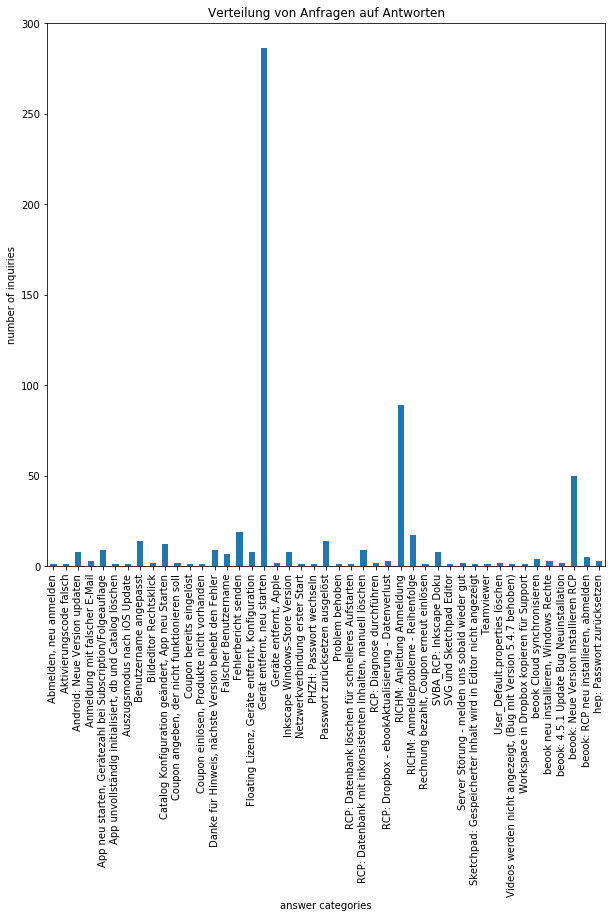

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline
fig = plt.figure(figsize=(10, 10))

q_and_a_corpus.groupby('answer').inquiry.count().plot.bar(ylim=0)
plt.title('Verteilung von Anfragen auf Antworten')
plt.xlabel('answer categories')
plt.ylabel('number of inquiries')
plt.show()

#### Kategorisierte Daten

In [33]:
len(q_and_a_corpus)

618